In [1]:
!pip install git+https://github.com/brianbt/btorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/brianbt/btorch to /tmp/pip-req-build-310zebg6
  Running command git clone -q https://github.com/brianbt/btorch /tmp/pip-req-build-310zebg6
  Created wheel for btorch: filename=btorch-0.0.1-py3-none-any.whl size=47850 sha256=bc99b16e5f3c598660497f2bbd4738dc4670335af782bc35ed2627419ceebbad
  Stored in directory: /tmp/pip-ephem-wheel-cache-fwkcyqhe/wheels/fa/ef/1e/1248ce8683f1b6fd8e6552260da8c1dcfbb352d899fef03d72
Successfully built btorch


In [2]:
import torch
import btorch
from btorch import nn
import btorch.nn.functional as F
from btorch.vision.utils import UnNormalize
from torchvision import transforms, datasets
from tqdm import tqdm
from matplotlib import pyplot as plt

# Load Dataset, CIFAR10

In [3]:
# Load CIFAR10 dataset, do augmentation on the trainset
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
transform_test = transforms.Compose([
  transforms.ToTensor()
  ])
trainset = datasets.CIFAR10('./cifar10',train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10('./cifar10',train=False, download=True, transform=transform_test)

# Only select the `dog` class
train_idx = torch.tensor(trainset.targets,dtype=torch.long) == 6
test_idx = torch.tensor(testset.targets,dtype=torch.long) == 6
trainset.targets = torch.tensor(trainset.targets,dtype=torch.long)[train_idx]
trainset.data = trainset.data[train_idx]
testset.targets = torch.tensor(testset.targets,dtype=torch.long)[test_idx]
testset.data = testset.data[test_idx]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [4]:
# Add to dataloader
batch_size = 16
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2, pin_memory=True, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True, drop_last=True)

# Create GAN Model

## Generator and Discriminator

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.input = nn.Linear(latent_dim, 64*3*3)
        self.c1 = nn.ConvTranspose2d(64, 32, 3, stride=2) #(32,7,7)
        self.bn1 = nn.BatchNorm2d(32)
        self.c2 = nn.ConvTranspose2d(32, 16, 3, stride=2) #(64,14,14)
        self.bn2 = nn.BatchNorm2d(16)
        self.c3 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(8)
        self.c4 = nn.ConvTranspose2d(8, 3, 4)
    def forward(self,x):
        x=self.input(x)
        x=x.view(-1,64,3,3)
        x=torch.relu(self.bn1(self.c1(x)))#(32,7,7)
        x=torch.relu(self.bn2(self.c2(x)))#(16,15,15)
        x=torch.relu(self.bn3(self.c3(x)))#(8,29,29)
        x=torch.tanh(self.c4(x))#(3,32,32)
        return x
    def sample(self, batch_size = 1):
        noise = torch.randn(batch_size, self.latent_dim, device=self.device())
        return self.forward(noise)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.c1 = nn.Conv2d(3, 16, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.c2 = nn.Conv2d(16, 32, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.c3 = nn.Conv2d(32, 64, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(64)
        self.l = nn.Linear(1024, 1)
    def forward(self,x):
        x=F.leaky_relu(self.bn1(self.c1(x)))#(16, 16, 16)
        x=F.leaky_relu(self.bn2(self.c2(x)))#(32, 8, 8)
        x=F.leaky_relu(self.bn3(self.c3(x)))#(64,4,4)
        x=torch.flatten(x, 1)
        return torch.sigmoid(self.l(x))
        

## Lets test the Generator and Discriminator output

In [7]:
g = Generator(100)
print(g.summary(input_size = (16,100)))
d = Discriminator()
print(d.summary(input_size=(16,3,32,32)))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [16, 3, 32, 32]           --
├─Linear: 1-1                            [16, 576]                 58,176
├─ConvTranspose2d: 1-2                   [16, 32, 7, 7]            18,464
├─BatchNorm2d: 1-3                       [16, 32, 7, 7]            64
├─ConvTranspose2d: 1-4                   [16, 16, 15, 15]          4,624
├─BatchNorm2d: 1-5                       [16, 16, 15, 15]          32
├─ConvTranspose2d: 1-6                   [16, 8, 29, 29]           1,160
├─BatchNorm2d: 1-7                       [16, 8, 29, 29]           16
├─ConvTranspose2d: 1-8                   [16, 3, 32, 32]           387
Total params: 82,923
Trainable params: 82,923
Non-trainable params: 0
Total mult-adds (M): 54.00
Input size (MB): 0.01
Forward/backward pass size (MB): 3.51
Params size (MB): 0.33
Estimated Total Size (MB): 3.85
Layer (type:depth-idx)                   Output Shape              P

## Create GAN Module

In [8]:
class GAN(nn.Module):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.g=Generator(latent_dim)
        self.d=Discriminator()
    def forward(self,x):
        return self.d(x)
    def sample(self, batch_size):
        return self.g.sample(batch_size)
    
    @classmethod
    def train_epoch(cls, net, criterion, trainloader, optimizer, epoch_idx, device='cuda', config=None):
        """This is the very basic training function for one epoch. Override this function when necessary
            
        Returns:
            (float): train_loss
        """
        net.g.train()
        net.d.train()
        G_loss = 0
        D_loss = 0
        G_curr_loss = 0 
        D_curr_loss = torch.nan
        pbar = tqdm(enumerate(trainloader), total=len(trainloader))
        for batch_idx, (inputs, targets) in pbar:
            # Trian G ###############################
            optimizer['G'].zero_grad()
            fake_inputs = net.sample(inputs.shape[0])
            fool_labels = torch.ones(inputs.shape[0], device=net.device())
            # fool_labels = torch.zeros(inputs.shape[0], device=net.device())
            fool_predicted = net.d(fake_inputs).view(-1)
            G_fool_loss = criterion(fool_predicted, fool_labels)
            # G_fool_loss = criterion(fool_predicted, fool_labels)*-1
            G_fool_loss.backward()
            
            optimizer['G'].step()
            G_curr_loss = G_fool_loss.item()
            G_loss += G_curr_loss
            
            # Trian D ###############################
            if epoch_idx >= 0: # train Discriminator less
                optimizer['D'].zero_grad()
                ## Train with real data
                inputs = inputs.to(device)
                real_labels = torch.ones(inputs.shape[0], device=net.device())
                real_predicted = net.d(inputs).view(-1)
                D_real_loss = criterion(real_predicted, real_labels)

                ## Train with fake data
                fake_labels = torch.zeros(inputs.shape[0], device=net.device())
                fake_predicted = net.d(fake_inputs.detach()).view(-1)
                D_fake_loss = criterion(fake_predicted, fake_labels)

                D_curr_lossB = (D_real_loss+D_fake_loss)/2
                D_curr_lossB.backward()
                optimizer['D'].step()
                
                D_curr_loss = D_curr_lossB.item()
                D_loss = D_loss + D_curr_loss
            
            pbar.set_description(
                f"epoch {epoch_idx+1} iter {batch_idx}: D loss {D_curr_loss:.5f}, G loss {G_curr_loss:.5f}.")
        return {'D_loss': D_loss/(batch_idx+1), 'G_loss': G_loss/(batch_idx+1)}

    @classmethod
    def before_each_train_epoch(cls, net, criterion, optimizer, trainloader, testloader=None, epoch=0, lr_scheduler=None, config=None):
      config['evol'].append(net.sample(1))

    @classmethod
    def test_epoch(cls, net, criterion, testloader, epoch_idx=0, device='cuda', config=None):
        """This is the very basic evaluating function for one epoch. Override this function when necessary
            
        Returns:
            (float): eval_loss
        """
        net.g.eval()
        net.d.eval()
        G_loss = 0
        D_loss = 0
        with torch.inference_mode():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                # Test G ###############################
                fake_inputs = net.sample(inputs.shape[0])
                fool_labels = torch.ones(inputs.shape[0], device=net.device())
                fool_predicted = net.d(fake_inputs).view(-1)
                G_fool_loss = criterion(fool_predicted, fool_labels)
                G_loss += G_fool_loss.item()
                
                
                # Test D ###############################
                if epoch_idx >= 0:
                    ## Test with real data
                    inputs = inputs.to(device)
                    real_labels = torch.ones(inputs.shape[0], device=net.device())
                    real_predicted = net.d(inputs).view(-1)
                    D_real_loss = criterion(real_predicted, real_labels)

                    ## Test with fake data
                    fake_labels = torch.zeros(inputs.shape[0], device=net.device())
                    fake_predicted = net.d(fake_inputs).view(-1)
                    D_fake_loss = criterion(fake_predicted, fake_labels)

                    D_loss = D_loss + (D_real_loss.item() + D_fake_loss.item())/2

                
                
        return {'D_loss': D_loss/(batch_idx+1), 'G_loss': G_loss/(batch_idx+1)}

## Paper init weight as (0, 0.02)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Init Model

In [10]:
# Model
latent_dim = 100
gan = GAN(latent_dim)
gan.g.apply(weights_init)
gan.d.apply(weights_init)

# Loss & Optimizer & Config
gan._lossfn = nn.BCELoss()
gan._optimizer = {'D':torch.optim.Adam(gan.d.parameters(), lr=0.0002, betas=(0.5, 0.999)),
                  'G':torch.optim.Adam(gan.g.parameters(), lr=0.0002, betas=(0.5, 0.999))}
gan._config['max_epoch'] = 200
gan._config['val_freq'] = 5
gan._config['evol'] = []

# Set GPU
gan.auto_gpu()

auto_gpu: using GPU (Tesla T4)


## Training

In [11]:
gan.fit(train_loader, validation_data=test_loader)

epoch 1 iter 311: D loss 0.20571, G loss 1.84862.: 100%|██████████| 312/312 [00:06<00:00, 50.29it/s]


Epoch 0: Training loss: {'D_loss': 0.21029867918397754, 'G_loss': 2.098259392648171}. Testing loss: {'D_loss': 0.8292451635483773, 'G_loss': 0.3040639558626759}


epoch 2 iter 311: D loss 0.14297, G loss 2.60249.: 100%|██████████| 312/312 [00:06<00:00, 51.14it/s]

Epoch 1: Training loss: {'D_loss': 0.13412961086783654, 'G_loss': 2.8924039938510995}. Testing loss: Not Provided



epoch 3 iter 311: D loss 0.14856, G loss 2.97547.: 100%|██████████| 312/312 [00:06<00:00, 51.60it/s]

Epoch 2: Training loss: {'D_loss': 0.12209657705030762, 'G_loss': 3.1540015699007573}. Testing loss: Not Provided



epoch 4 iter 311: D loss 0.10961, G loss 2.85596.: 100%|██████████| 312/312 [00:06<00:00, 51.32it/s]

Epoch 3: Training loss: {'D_loss': 0.21368514981049186, 'G_loss': 2.80236336378715}. Testing loss: Not Provided



epoch 5 iter 311: D loss 0.06891, G loss 3.17294.: 100%|██████████| 312/312 [00:06<00:00, 49.61it/s]

Epoch 4: Training loss: {'D_loss': 0.21864309763679138, 'G_loss': 2.466029515442176}. Testing loss: Not Provided



epoch 6 iter 311: D loss 0.18370, G loss 1.72123.: 100%|██████████| 312/312 [00:06<00:00, 48.78it/s]


Epoch 5: Training loss: {'D_loss': 0.2235184424700072, 'G_loss': 2.5697732098782673}. Testing loss: {'D_loss': 0.8151553564614826, 'G_loss': 2.2342874100131374}


epoch 7 iter 311: D loss 0.22825, G loss 2.22383.: 100%|██████████| 312/312 [00:06<00:00, 51.30it/s]

Epoch 6: Training loss: {'D_loss': 0.2761225584201897, 'G_loss': 2.227529993041968}. Testing loss: Not Provided



epoch 8 iter 311: D loss 0.14721, G loss 2.92889.: 100%|██████████| 312/312 [00:06<00:00, 50.67it/s]


Epoch 7: Training loss: {'D_loss': 0.2629908049861208, 'G_loss': 2.2645229375324187}. Testing loss: Not Provided


epoch 9 iter 311: D loss 0.40789, G loss 1.14847.: 100%|██████████| 312/312 [00:06<00:00, 51.58it/s]


Epoch 8: Training loss: {'D_loss': 0.2818964533507824, 'G_loss': 2.278802672544351}. Testing loss: Not Provided


epoch 10 iter 311: D loss 0.32659, G loss 1.50168.: 100%|██████████| 312/312 [00:06<00:00, 51.69it/s]

Epoch 9: Training loss: {'D_loss': 0.28928976812853646, 'G_loss': 2.2337384707628725}. Testing loss: Not Provided



epoch 11 iter 311: D loss 0.19041, G loss 2.23526.: 100%|██████████| 312/312 [00:06<00:00, 50.74it/s]


Epoch 10: Training loss: {'D_loss': 0.31032911535256946, 'G_loss': 2.1149562331250844}. Testing loss: {'D_loss': 0.3748799919361068, 'G_loss': 1.1458769094559453}


epoch 12 iter 311: D loss 0.40012, G loss 1.23200.: 100%|██████████| 312/312 [00:06<00:00, 51.35it/s]


Epoch 11: Training loss: {'D_loss': 0.2796387546695769, 'G_loss': 2.264664376106782}. Testing loss: Not Provided


epoch 13 iter 311: D loss 0.52898, G loss 0.92461.: 100%|██████████| 312/312 [00:06<00:00, 51.38it/s]


Epoch 12: Training loss: {'D_loss': 0.2884386860741637, 'G_loss': 2.3380280095033155}. Testing loss: Not Provided


epoch 14 iter 311: D loss 0.62931, G loss 2.90602.: 100%|██████████| 312/312 [00:06<00:00, 51.83it/s]

Epoch 13: Training loss: {'D_loss': 0.2671145164789871, 'G_loss': 2.355892555644879}. Testing loss: Not Provided



epoch 15 iter 311: D loss 0.30947, G loss 1.83383.: 100%|██████████| 312/312 [00:06<00:00, 47.19it/s]

Epoch 14: Training loss: {'D_loss': 0.27788814430674297, 'G_loss': 2.42293115810324}. Testing loss: Not Provided



epoch 16 iter 311: D loss 0.36433, G loss 2.23784.: 100%|██████████| 312/312 [00:06<00:00, 51.10it/s]


Epoch 15: Training loss: {'D_loss': 0.290883873637097, 'G_loss': 2.3528844110476665}. Testing loss: {'D_loss': 0.3844038407889105, 'G_loss': 1.0708586804328426}


epoch 17 iter 311: D loss 0.43634, G loss 2.19722.: 100%|██████████| 312/312 [00:06<00:00, 51.02it/s]

Epoch 16: Training loss: {'D_loss': 0.28313256298096323, 'G_loss': 2.328336932338201}. Testing loss: Not Provided



epoch 18 iter 311: D loss 0.42023, G loss 1.67082.: 100%|██████████| 312/312 [00:06<00:00, 50.91it/s]

Epoch 17: Training loss: {'D_loss': 0.2813973036379768, 'G_loss': 2.354044688626742}. Testing loss: Not Provided



epoch 19 iter 311: D loss 0.17780, G loss 3.01256.: 100%|██████████| 312/312 [00:06<00:00, 51.22it/s]


Epoch 18: Training loss: {'D_loss': 0.195159198411812, 'G_loss': 2.8145714289484878}. Testing loss: Not Provided


epoch 20 iter 311: D loss 0.33172, G loss 3.39853.: 100%|██████████| 312/312 [00:06<00:00, 50.80it/s]

Epoch 19: Training loss: {'D_loss': 0.14496586447020468, 'G_loss': 3.2079057221133738}. Testing loss: Not Provided



epoch 21 iter 311: D loss 0.33821, G loss 2.09120.: 100%|██████████| 312/312 [00:06<00:00, 50.50it/s]


Epoch 20: Training loss: {'D_loss': 0.2464771329676016, 'G_loss': 2.6193097058014994}. Testing loss: {'D_loss': 0.34316340800855427, 'G_loss': 1.2306565565447654}


epoch 22 iter 311: D loss 0.82629, G loss 0.82512.: 100%|██████████| 312/312 [00:06<00:00, 51.42it/s]

Epoch 21: Training loss: {'D_loss': 0.3184272884510649, 'G_loss': 2.2574382523695626}. Testing loss: Not Provided



epoch 23 iter 311: D loss 0.28289, G loss 3.36387.: 100%|██████████| 312/312 [00:06<00:00, 50.29it/s]

Epoch 22: Training loss: {'D_loss': 0.2325983015844264, 'G_loss': 2.592047261599547}. Testing loss: Not Provided



epoch 24 iter 311: D loss 0.31710, G loss 1.69897.: 100%|██████████| 312/312 [00:06<00:00, 51.03it/s]


Epoch 23: Training loss: {'D_loss': 0.28597954005146253, 'G_loss': 2.5697874134549727}. Testing loss: Not Provided


epoch 25 iter 311: D loss 0.28028, G loss 1.16505.: 100%|██████████| 312/312 [00:06<00:00, 49.67it/s]

Epoch 24: Training loss: {'D_loss': 0.2355589993083133, 'G_loss': 2.580269173647349}. Testing loss: Not Provided



epoch 26 iter 311: D loss 0.11458, G loss 3.40430.: 100%|██████████| 312/312 [00:06<00:00, 49.99it/s]


Epoch 25: Training loss: {'D_loss': 0.20941952669407982, 'G_loss': 2.827100621106533}. Testing loss: {'D_loss': 0.1445011094573044, 'G_loss': 2.1506923956255757}


epoch 27 iter 311: D loss 0.26673, G loss 2.14175.: 100%|██████████| 312/312 [00:06<00:00, 50.24it/s]


Epoch 26: Training loss: {'D_loss': 0.21706921794714454, 'G_loss': 2.9230478369654755}. Testing loss: Not Provided


epoch 28 iter 311: D loss 0.12757, G loss 2.22097.: 100%|██████████| 312/312 [00:06<00:00, 50.11it/s]

Epoch 27: Training loss: {'D_loss': 0.1802545436956466, 'G_loss': 3.1381183114762488}. Testing loss: Not Provided



epoch 29 iter 311: D loss 0.20813, G loss 2.57955.: 100%|██████████| 312/312 [00:06<00:00, 51.11it/s]

Epoch 28: Training loss: {'D_loss': 0.15754954123463577, 'G_loss': 3.221664149624606}. Testing loss: Not Provided



epoch 30 iter 311: D loss 0.20608, G loss 3.58956.: 100%|██████████| 312/312 [00:06<00:00, 50.55it/s]

Epoch 29: Training loss: {'D_loss': 0.16371804948311108, 'G_loss': 3.111715244559141}. Testing loss: Not Provided



epoch 31 iter 311: D loss 0.10039, G loss 2.40251.: 100%|██████████| 312/312 [00:06<00:00, 50.91it/s]


Epoch 30: Training loss: {'D_loss': 0.18675815589570752, 'G_loss': 3.1746082559036903}. Testing loss: {'D_loss': 0.17614747809186096, 'G_loss': 1.8844051841766603}


epoch 32 iter 311: D loss 0.06358, G loss 2.70255.: 100%|██████████| 312/312 [00:06<00:00, 51.02it/s]

Epoch 31: Training loss: {'D_loss': 0.1989613399685671, 'G_loss': 3.127752093502726}. Testing loss: Not Provided



epoch 33 iter 311: D loss 0.20230, G loss 1.87110.: 100%|██████████| 312/312 [00:06<00:00, 50.70it/s]

Epoch 32: Training loss: {'D_loss': 0.2561982658823045, 'G_loss': 2.6668937544887648}. Testing loss: Not Provided



epoch 34 iter 311: D loss 0.29403, G loss 3.04706.: 100%|██████████| 312/312 [00:06<00:00, 50.88it/s]

Epoch 33: Training loss: {'D_loss': 0.14537456146223496, 'G_loss': 3.2995943930477667}. Testing loss: Not Provided



epoch 35 iter 311: D loss 0.07926, G loss 2.57508.: 100%|██████████| 312/312 [00:06<00:00, 50.13it/s]

Epoch 34: Training loss: {'D_loss': 0.19990971977583682, 'G_loss': 2.99635608943227}. Testing loss: Not Provided



epoch 36 iter 311: D loss 0.07950, G loss 3.60064.: 100%|██████████| 312/312 [00:06<00:00, 50.74it/s]


Epoch 35: Training loss: {'D_loss': 0.15556076001853514, 'G_loss': 3.500097927255317}. Testing loss: {'D_loss': 0.5616103970716076, 'G_loss': 1.573751618785243}


epoch 37 iter 311: D loss 0.10687, G loss 2.89124.: 100%|██████████| 312/312 [00:06<00:00, 50.48it/s]

Epoch 36: Training loss: {'D_loss': 0.19355914878467909, 'G_loss': 3.1631390613814196}. Testing loss: Not Provided



epoch 38 iter 311: D loss 0.45391, G loss 4.90269.: 100%|██████████| 312/312 [00:06<00:00, 50.66it/s]

Epoch 37: Training loss: {'D_loss': 0.23951697782374537, 'G_loss': 2.979017323682992}. Testing loss: Not Provided



epoch 39 iter 311: D loss 0.17843, G loss 2.96834.: 100%|██████████| 312/312 [00:06<00:00, 50.97it/s]

Epoch 38: Training loss: {'D_loss': 0.21597109503375414, 'G_loss': 2.8460150249302387}. Testing loss: Not Provided



epoch 40 iter 311: D loss 0.08409, G loss 2.45071.: 100%|██████████| 312/312 [00:06<00:00, 49.75it/s]


Epoch 39: Training loss: {'D_loss': 0.19999668212870184, 'G_loss': 3.11086387005754}. Testing loss: Not Provided


epoch 41 iter 311: D loss 0.04888, G loss 3.11563.: 100%|██████████| 312/312 [00:06<00:00, 50.56it/s]


Epoch 40: Training loss: {'D_loss': 0.17182498001672614, 'G_loss': 3.1830963345292287}. Testing loss: {'D_loss': 0.4130842208621963, 'G_loss': 1.2471943920658481}


epoch 42 iter 311: D loss 0.03933, G loss 3.47978.: 100%|██████████| 312/312 [00:06<00:00, 49.74it/s]

Epoch 41: Training loss: {'D_loss': 0.16490851866845518, 'G_loss': 3.4389564596498623}. Testing loss: Not Provided



epoch 43 iter 311: D loss 0.09972, G loss 3.39359.: 100%|██████████| 312/312 [00:06<00:00, 50.16it/s]

Epoch 42: Training loss: {'D_loss': 0.23695989763244796, 'G_loss': 2.790875356214551}. Testing loss: Not Provided



epoch 44 iter 311: D loss 0.17533, G loss 3.12817.: 100%|██████████| 312/312 [00:06<00:00, 50.00it/s]

Epoch 43: Training loss: {'D_loss': 0.16031821991185632, 'G_loss': 3.409150432747526}. Testing loss: Not Provided



epoch 45 iter 311: D loss 0.06298, G loss 3.03883.: 100%|██████████| 312/312 [00:06<00:00, 50.44it/s]

Epoch 44: Training loss: {'D_loss': 0.19026184532468995, 'G_loss': 3.043719606426282}. Testing loss: Not Provided



epoch 46 iter 311: D loss 0.35887, G loss 1.22501.: 100%|██████████| 312/312 [00:06<00:00, 49.91it/s]


Epoch 45: Training loss: {'D_loss': 0.17585207061403288, 'G_loss': 3.158045280677004}. Testing loss: {'D_loss': 0.46346835719962276, 'G_loss': 1.3544469312314065}


epoch 47 iter 311: D loss 0.11613, G loss 2.22373.: 100%|██████████| 312/312 [00:06<00:00, 50.21it/s]

Epoch 46: Training loss: {'D_loss': 0.27947729766273344, 'G_loss': 2.3584854568426428}. Testing loss: Not Provided



epoch 48 iter 311: D loss 0.36003, G loss 1.63870.: 100%|██████████| 312/312 [00:06<00:00, 50.20it/s]

Epoch 47: Training loss: {'D_loss': 0.3328812418099588, 'G_loss': 2.1979808296339636}. Testing loss: Not Provided



epoch 49 iter 311: D loss 0.31973, G loss 1.65320.: 100%|██████████| 312/312 [00:06<00:00, 49.58it/s]

Epoch 48: Training loss: {'D_loss': 0.2901389913466305, 'G_loss': 2.396626632935248}. Testing loss: Not Provided



epoch 50 iter 311: D loss 0.08683, G loss 4.07721.: 100%|██████████| 312/312 [00:06<00:00, 50.54it/s]

Epoch 49: Training loss: {'D_loss': 0.17002279818272933, 'G_loss': 3.2308435902381554}. Testing loss: Not Provided



epoch 51 iter 311: D loss 0.00778, G loss 6.00327.: 100%|██████████| 312/312 [00:06<00:00, 49.88it/s]


Epoch 50: Training loss: {'D_loss': 0.16514688344875303, 'G_loss': 3.2697689602963433}. Testing loss: {'D_loss': 0.6302340001829209, 'G_loss': 1.3341497721210602}


epoch 52 iter 311: D loss 0.30303, G loss 1.67629.: 100%|██████████| 312/312 [00:06<00:00, 50.49it/s]

Epoch 51: Training loss: {'D_loss': 0.17753087878466034, 'G_loss': 3.443118948322267}. Testing loss: Not Provided



epoch 53 iter 311: D loss 0.03408, G loss 4.95645.: 100%|██████████| 312/312 [00:06<00:00, 50.08it/s]

Epoch 52: Training loss: {'D_loss': 0.12999901939661074, 'G_loss': 3.586109401180576}. Testing loss: Not Provided



epoch 54 iter 311: D loss 0.15885, G loss 1.85924.: 100%|██████████| 312/312 [00:06<00:00, 49.87it/s]

Epoch 53: Training loss: {'D_loss': 0.14336194494106352, 'G_loss': 3.5709438832142415}. Testing loss: Not Provided



epoch 55 iter 311: D loss 0.13640, G loss 2.07972.: 100%|██████████| 312/312 [00:06<00:00, 50.30it/s]

Epoch 54: Training loss: {'D_loss': 0.157314442566787, 'G_loss': 3.556861070677256}. Testing loss: Not Provided



epoch 56 iter 311: D loss 0.01610, G loss 4.93324.: 100%|██████████| 312/312 [00:06<00:00, 50.04it/s]


Epoch 55: Training loss: {'D_loss': 0.1601459104508066, 'G_loss': 3.3222668326746385}. Testing loss: {'D_loss': 0.6616588934294639, 'G_loss': 1.2888431251049042}


epoch 57 iter 311: D loss 0.02149, G loss 3.74874.: 100%|██████████| 312/312 [00:06<00:00, 50.55it/s]

Epoch 56: Training loss: {'D_loss': 0.054581822003596105, 'G_loss': 4.214199962715308}. Testing loss: Not Provided



epoch 58 iter 311: D loss 0.04557, G loss 3.22351.: 100%|██████████| 312/312 [00:06<00:00, 50.33it/s]

Epoch 57: Training loss: {'D_loss': 0.0847265517054322, 'G_loss': 4.195690484860768}. Testing loss: Not Provided



epoch 59 iter 311: D loss 0.38095, G loss 1.10931.: 100%|██████████| 312/312 [00:06<00:00, 48.58it/s]


Epoch 58: Training loss: {'D_loss': 0.10424660836668828, 'G_loss': 4.003317881471071}. Testing loss: Not Provided


epoch 60 iter 311: D loss 0.36260, G loss 5.86190.: 100%|██████████| 312/312 [00:06<00:00, 50.15it/s]

Epoch 59: Training loss: {'D_loss': 0.11404647618362035, 'G_loss': 4.109092230878723}. Testing loss: Not Provided



epoch 61 iter 311: D loss 0.05402, G loss 3.32649.: 100%|██████████| 312/312 [00:06<00:00, 45.74it/s]


Epoch 60: Training loss: {'D_loss': 0.1064766775973392, 'G_loss': 3.947952994802155}. Testing loss: {'D_loss': 0.5509430764903945, 'G_loss': 1.650820952269339}


epoch 62 iter 311: D loss 0.01267, G loss 4.48873.: 100%|██████████| 312/312 [00:06<00:00, 49.48it/s]

Epoch 61: Training loss: {'D_loss': 0.06713786835928495, 'G_loss': 4.26969266625551}. Testing loss: Not Provided



epoch 63 iter 311: D loss 0.04190, G loss 5.01599.: 100%|██████████| 312/312 [00:06<00:00, 49.70it/s]

Epoch 62: Training loss: {'D_loss': 0.06271441858366299, 'G_loss': 4.655154601378271}. Testing loss: Not Provided



epoch 64 iter 311: D loss 0.08411, G loss 3.44223.: 100%|██████████| 312/312 [00:06<00:00, 50.30it/s]

Epoch 63: Training loss: {'D_loss': 0.119103087092905, 'G_loss': 3.9435520323041158}. Testing loss: Not Provided



epoch 65 iter 311: D loss 0.06196, G loss 3.83306.: 100%|██████████| 312/312 [00:06<00:00, 49.50it/s]

Epoch 64: Training loss: {'D_loss': 0.1397329777992593, 'G_loss': 3.3221593762819586}. Testing loss: Not Provided



epoch 66 iter 311: D loss 0.13957, G loss 2.42453.: 100%|██████████| 312/312 [00:06<00:00, 50.18it/s]


Epoch 65: Training loss: {'D_loss': 0.14736998591942188, 'G_loss': 3.437646634590167}. Testing loss: {'D_loss': 1.2204504211343103, 'G_loss': 1.701985284205406}


epoch 67 iter 311: D loss 0.15441, G loss 2.40114.: 100%|██████████| 312/312 [00:06<00:00, 50.02it/s]


Epoch 66: Training loss: {'D_loss': 0.13856230444836024, 'G_loss': 3.7449293608586185}. Testing loss: Not Provided


epoch 68 iter 311: D loss 0.11545, G loss 3.18893.: 100%|██████████| 312/312 [00:06<00:00, 49.56it/s]

Epoch 67: Training loss: {'D_loss': 0.1507649842190007, 'G_loss': 3.7543631921498437}. Testing loss: Not Provided



epoch 69 iter 311: D loss 0.12228, G loss 2.46741.: 100%|██████████| 312/312 [00:06<00:00, 50.07it/s]


Epoch 68: Training loss: {'D_loss': 0.15342839016543272, 'G_loss': 3.3682604060532193}. Testing loss: Not Provided


epoch 70 iter 311: D loss 0.20935, G loss 2.36103.: 100%|██████████| 312/312 [00:06<00:00, 49.11it/s]


Epoch 69: Training loss: {'D_loss': 0.17283263087917405, 'G_loss': 3.087665480680955}. Testing loss: Not Provided


epoch 71 iter 311: D loss 0.09091, G loss 3.54129.: 100%|██████████| 312/312 [00:06<00:00, 49.51it/s]


Epoch 70: Training loss: {'D_loss': 0.17479681244227463, 'G_loss': 3.4894872826452437}. Testing loss: {'D_loss': 0.851904827260202, 'G_loss': 1.440168160584665}


epoch 72 iter 311: D loss 0.02797, G loss 3.94825.: 100%|██████████| 312/312 [00:06<00:00, 48.34it/s]


Epoch 71: Training loss: {'D_loss': 0.15667790372987303, 'G_loss': 3.4667596181329245}. Testing loss: Not Provided


epoch 73 iter 311: D loss 0.06844, G loss 2.64429.: 100%|██████████| 312/312 [00:06<00:00, 49.04it/s]

Epoch 72: Training loss: {'D_loss': 0.11006672574708667, 'G_loss': 3.756299204742297}. Testing loss: Not Provided



epoch 74 iter 311: D loss 0.11814, G loss 2.15114.: 100%|██████████| 312/312 [00:06<00:00, 49.12it/s]

Epoch 73: Training loss: {'D_loss': 0.15653724328223736, 'G_loss': 3.427885436429045}. Testing loss: Not Provided



epoch 75 iter 311: D loss 0.09220, G loss 3.46950.: 100%|██████████| 312/312 [00:06<00:00, 48.60it/s]


Epoch 74: Training loss: {'D_loss': 0.17179235293028447, 'G_loss': 3.160782582484759}. Testing loss: Not Provided


epoch 76 iter 311: D loss 0.16420, G loss 3.01294.: 100%|██████████| 312/312 [00:06<00:00, 49.46it/s]


Epoch 75: Training loss: {'D_loss': 0.1556376383627932, 'G_loss': 3.1103608084317202}. Testing loss: {'D_loss': 0.3342953653885953, 'G_loss': 1.2054152469481192}


epoch 77 iter 311: D loss 0.27427, G loss 1.21255.: 100%|██████████| 312/312 [00:06<00:00, 49.18it/s]

Epoch 76: Training loss: {'D_loss': 0.1928382770707592, 'G_loss': 2.9633532071915956}. Testing loss: Not Provided



epoch 78 iter 311: D loss 0.01640, G loss 4.71123.: 100%|██████████| 312/312 [00:06<00:00, 50.19it/s]


Epoch 77: Training loss: {'D_loss': 0.1376063895250599, 'G_loss': 3.728474570103945}. Testing loss: Not Provided


epoch 79 iter 311: D loss 0.03159, G loss 5.12208.: 100%|██████████| 312/312 [00:06<00:00, 49.60it/s]

Epoch 78: Training loss: {'D_loss': 0.12884956852604562, 'G_loss': 3.652577771781347}. Testing loss: Not Provided



epoch 80 iter 311: D loss 0.25099, G loss 4.92782.: 100%|██████████| 312/312 [00:06<00:00, 49.81it/s]

Epoch 79: Training loss: {'D_loss': 0.1683607351897547, 'G_loss': 3.4324942904237945}. Testing loss: Not Provided



epoch 81 iter 311: D loss 0.17534, G loss 1.97667.: 100%|██████████| 312/312 [00:06<00:00, 49.39it/s]


Epoch 80: Training loss: {'D_loss': 0.170922756066713, 'G_loss': 3.5753081233766024}. Testing loss: {'D_loss': 0.38472173435072743, 'G_loss': 1.1638079285621643}


epoch 82 iter 311: D loss 0.50684, G loss 6.19890.: 100%|██████████| 312/312 [00:06<00:00, 49.34it/s]

Epoch 81: Training loss: {'D_loss': 0.17057476311516112, 'G_loss': 3.109856482404165}. Testing loss: Not Provided



epoch 83 iter 311: D loss 0.26607, G loss 2.65802.: 100%|██████████| 312/312 [00:06<00:00, 49.54it/s]

Epoch 82: Training loss: {'D_loss': 0.1876170655267719, 'G_loss': 2.8845396374280634}. Testing loss: Not Provided



epoch 84 iter 311: D loss 0.05590, G loss 4.24117.: 100%|██████████| 312/312 [00:06<00:00, 49.18it/s]

Epoch 83: Training loss: {'D_loss': 0.19895487831523403, 'G_loss': 2.931694112909146}. Testing loss: Not Provided



epoch 85 iter 311: D loss 0.08834, G loss 4.65183.: 100%|██████████| 312/312 [00:06<00:00, 49.80it/s]

Epoch 84: Training loss: {'D_loss': 0.16805115063638928, 'G_loss': 3.2900061266651996}. Testing loss: Not Provided



epoch 86 iter 311: D loss 0.06033, G loss 4.16838.: 100%|██████████| 312/312 [00:06<00:00, 48.84it/s]


Epoch 85: Training loss: {'D_loss': 0.1549448794207703, 'G_loss': 3.4264706103847575}. Testing loss: {'D_loss': 0.8743887358615475, 'G_loss': 1.075162338633691}


epoch 87 iter 311: D loss 0.02816, G loss 5.79860.: 100%|██████████| 312/312 [00:06<00:00, 48.88it/s]

Epoch 86: Training loss: {'D_loss': 0.14375689901405564, 'G_loss': 3.586054932564879}. Testing loss: Not Provided



epoch 88 iter 311: D loss 0.07768, G loss 2.81519.: 100%|██████████| 312/312 [00:06<00:00, 49.56it/s]

Epoch 87: Training loss: {'D_loss': 0.16115279329749635, 'G_loss': 3.2632056492356916}. Testing loss: Not Provided



epoch 89 iter 311: D loss 0.08082, G loss 4.14885.: 100%|██████████| 312/312 [00:06<00:00, 48.57it/s]

Epoch 88: Training loss: {'D_loss': 0.1788985158663052, 'G_loss': 3.0925845156113305}. Testing loss: Not Provided



epoch 90 iter 311: D loss 0.05061, G loss 4.84554.: 100%|██████████| 312/312 [00:06<00:00, 49.30it/s]

Epoch 89: Training loss: {'D_loss': 0.14225899763345623, 'G_loss': 3.3755706378664727}. Testing loss: Not Provided



epoch 91 iter 311: D loss 0.29566, G loss 4.62075.: 100%|██████████| 312/312 [00:06<00:00, 48.86it/s]


Epoch 90: Training loss: {'D_loss': 0.18755055249382097, 'G_loss': 3.3497055262440623}. Testing loss: {'D_loss': 0.36667304690326413, 'G_loss': 1.2979104816913605}


epoch 92 iter 311: D loss 0.71497, G loss 5.53573.: 100%|██████████| 312/312 [00:06<00:00, 48.66it/s]

Epoch 91: Training loss: {'D_loss': 0.21570996273285112, 'G_loss': 2.8681669407165966}. Testing loss: Not Provided



epoch 93 iter 311: D loss 0.10406, G loss 3.07531.: 100%|██████████| 312/312 [00:06<00:00, 48.98it/s]

Epoch 92: Training loss: {'D_loss': 0.17887346362933898, 'G_loss': 3.3881598697640958}. Testing loss: Not Provided



epoch 94 iter 311: D loss 0.02547, G loss 4.35541.: 100%|██████████| 312/312 [00:06<00:00, 49.88it/s]


Epoch 93: Training loss: {'D_loss': 0.16412064714882618, 'G_loss': 3.406130315783696}. Testing loss: Not Provided


epoch 95 iter 311: D loss 0.29369, G loss 2.45465.: 100%|██████████| 312/312 [00:06<00:00, 49.05it/s]

Epoch 94: Training loss: {'D_loss': 0.15706274165915182, 'G_loss': 3.3870237024071126}. Testing loss: Not Provided



epoch 96 iter 311: D loss 0.14447, G loss 3.17814.: 100%|██████████| 312/312 [00:06<00:00, 48.22it/s]


Epoch 95: Training loss: {'D_loss': 0.20482533044802645, 'G_loss': 2.9732454296392508}. Testing loss: {'D_loss': 0.31053871741647937, 'G_loss': 1.4304007618658003}


epoch 97 iter 311: D loss 0.10765, G loss 3.39507.: 100%|██████████| 312/312 [00:06<00:00, 49.40it/s]

Epoch 96: Training loss: {'D_loss': 0.20741176318663818, 'G_loss': 2.781057755725506}. Testing loss: Not Provided



epoch 98 iter 311: D loss 0.14429, G loss 3.32500.: 100%|██████████| 312/312 [00:06<00:00, 48.57it/s]


Epoch 97: Training loss: {'D_loss': 0.18574719295168343, 'G_loss': 3.2075212387702403}. Testing loss: Not Provided


epoch 99 iter 311: D loss 0.19449, G loss 3.52843.: 100%|██████████| 312/312 [00:06<00:00, 48.33it/s]

Epoch 98: Training loss: {'D_loss': 0.20415545919408593, 'G_loss': 3.0258036016558227}. Testing loss: Not Provided



epoch 100 iter 311: D loss 0.34341, G loss 1.09705.: 100%|██████████| 312/312 [00:06<00:00, 48.77it/s]


Epoch 99: Training loss: {'D_loss': 0.20783672361479452, 'G_loss': 3.171155849376168}. Testing loss: Not Provided


epoch 101 iter 311: D loss 0.13406, G loss 2.09975.: 100%|██████████| 312/312 [00:06<00:00, 48.29it/s]


Epoch 100: Training loss: {'D_loss': 0.23169289372312143, 'G_loss': 2.8101702603774195}. Testing loss: {'D_loss': 0.4093582944178413, 'G_loss': 0.926011529660994}


epoch 102 iter 311: D loss 0.20178, G loss 2.67457.: 100%|██████████| 312/312 [00:06<00:00, 48.66it/s]

Epoch 101: Training loss: {'D_loss': 0.2109200110873924, 'G_loss': 2.780273889310849}. Testing loss: Not Provided



epoch 103 iter 311: D loss 0.24012, G loss 3.74303.: 100%|██████████| 312/312 [00:06<00:00, 48.87it/s]

Epoch 102: Training loss: {'D_loss': 0.21062876689486587, 'G_loss': 2.9321993491970577}. Testing loss: Not Provided



epoch 104 iter 311: D loss 0.21148, G loss 2.39708.: 100%|██████████| 312/312 [00:06<00:00, 48.84it/s]


Epoch 103: Training loss: {'D_loss': 0.21660215755661902, 'G_loss': 2.976913997569145}. Testing loss: Not Provided


epoch 105 iter 311: D loss 0.25167, G loss 1.89489.: 100%|██████████| 312/312 [00:06<00:00, 48.00it/s]

Epoch 104: Training loss: {'D_loss': 0.23439088124089325, 'G_loss': 2.727390081072465}. Testing loss: Not Provided



epoch 106 iter 311: D loss 0.41034, G loss 2.15065.: 100%|██████████| 312/312 [00:06<00:00, 44.90it/s]


Epoch 105: Training loss: {'D_loss': 0.2083389051974966, 'G_loss': 3.0771354850477133}. Testing loss: {'D_loss': 0.222017515630972, 'G_loss': 2.08141016767871}


epoch 107 iter 311: D loss 0.24431, G loss 1.35929.: 100%|██████████| 312/312 [00:06<00:00, 48.16it/s]


Epoch 106: Training loss: {'D_loss': 0.2305449785796018, 'G_loss': 2.76169420645023}. Testing loss: Not Provided


epoch 108 iter 311: D loss 0.31612, G loss 2.11977.: 100%|██████████| 312/312 [00:06<00:00, 48.25it/s]

Epoch 107: Training loss: {'D_loss': 0.22638513492897916, 'G_loss': 2.920187023205635}. Testing loss: Not Provided



epoch 109 iter 311: D loss 0.08585, G loss 6.35430.: 100%|██████████| 312/312 [00:06<00:00, 48.30it/s]

Epoch 108: Training loss: {'D_loss': 0.18116453377744898, 'G_loss': 3.153651700904354}. Testing loss: Not Provided



epoch 110 iter 311: D loss 0.22744, G loss 1.47439.: 100%|██████████| 312/312 [00:06<00:00, 47.62it/s]

Epoch 109: Training loss: {'D_loss': 0.20344792888499796, 'G_loss': 2.9579071251627727}. Testing loss: Not Provided



epoch 111 iter 311: D loss 0.09954, G loss 2.96926.: 100%|██████████| 312/312 [00:06<00:00, 48.80it/s]


Epoch 110: Training loss: {'D_loss': 0.18576050030951125, 'G_loss': 3.1480908955041413}. Testing loss: {'D_loss': 0.34616354864931875, 'G_loss': 2.0697675097373223}


epoch 112 iter 311: D loss 0.22619, G loss 3.18141.: 100%|██████████| 312/312 [00:06<00:00, 49.49it/s]

Epoch 111: Training loss: {'D_loss': 0.21002109165195948, 'G_loss': 3.0295644886791706}. Testing loss: Not Provided



epoch 113 iter 311: D loss 0.25374, G loss 1.46191.: 100%|██████████| 312/312 [00:06<00:00, 48.26it/s]

Epoch 112: Training loss: {'D_loss': 0.2279427419953908, 'G_loss': 2.9636257017652192}. Testing loss: Not Provided



epoch 114 iter 311: D loss 0.03343, G loss 3.46248.: 100%|██████████| 312/312 [00:06<00:00, 49.15it/s]

Epoch 113: Training loss: {'D_loss': 0.19147913420769888, 'G_loss': 3.226364747644999}. Testing loss: Not Provided



epoch 115 iter 311: D loss 0.08418, G loss 7.28731.: 100%|██████████| 312/312 [00:06<00:00, 48.12it/s]

Epoch 114: Training loss: {'D_loss': 0.18453070699858168, 'G_loss': 3.3666635919362307}. Testing loss: Not Provided



epoch 116 iter 311: D loss 0.06992, G loss 2.72541.: 100%|██████████| 312/312 [00:06<00:00, 49.00it/s]


Epoch 115: Training loss: {'D_loss': 0.19513980562512118, 'G_loss': 3.277681172801516}. Testing loss: {'D_loss': 0.19192207342524442, 'G_loss': 1.549057360618345}


epoch 117 iter 311: D loss 0.03288, G loss 4.75690.: 100%|██████████| 312/312 [00:06<00:00, 48.51it/s]

Epoch 116: Training loss: {'D_loss': 0.18080715947629264, 'G_loss': 3.4993761349947023}. Testing loss: Not Provided



epoch 118 iter 311: D loss 0.50839, G loss 1.28584.: 100%|██████████| 312/312 [00:06<00:00, 48.12it/s]

Epoch 117: Training loss: {'D_loss': 0.18168401784406832, 'G_loss': 3.3821419882468686}. Testing loss: Not Provided



epoch 119 iter 311: D loss 0.47867, G loss 1.89151.: 100%|██████████| 312/312 [00:06<00:00, 48.53it/s]


Epoch 118: Training loss: {'D_loss': 0.22243320190896973, 'G_loss': 3.015642960675252}. Testing loss: Not Provided


epoch 120 iter 311: D loss 0.26848, G loss 3.00136.: 100%|██████████| 312/312 [00:06<00:00, 48.01it/s]


Epoch 119: Training loss: {'D_loss': 0.2053389704834001, 'G_loss': 2.855370492889331}. Testing loss: Not Provided


epoch 121 iter 311: D loss 0.14164, G loss 3.55253.: 100%|██████████| 312/312 [00:06<00:00, 47.69it/s]


Epoch 120: Training loss: {'D_loss': 0.32725843554362655, 'G_loss': 2.6447663436142297}. Testing loss: {'D_loss': 0.4909777294003194, 'G_loss': 0.9303685042165941}


epoch 122 iter 311: D loss 0.26722, G loss 2.30517.: 100%|██████████| 312/312 [00:06<00:00, 46.93it/s]


Epoch 121: Training loss: {'D_loss': 0.2314226997849078, 'G_loss': 2.732112161600246}. Testing loss: Not Provided


epoch 123 iter 311: D loss 0.14434, G loss 3.17227.: 100%|██████████| 312/312 [00:06<00:00, 47.46it/s]


Epoch 122: Training loss: {'D_loss': 0.21571778709021133, 'G_loss': 2.9772955157244816}. Testing loss: Not Provided


epoch 124 iter 311: D loss 0.04511, G loss 2.97983.: 100%|██████████| 312/312 [00:06<00:00, 47.83it/s]

Epoch 123: Training loss: {'D_loss': 0.17633603524882346, 'G_loss': 3.1953892200612106}. Testing loss: Not Provided



epoch 125 iter 311: D loss 0.51202, G loss 1.81669.: 100%|██████████| 312/312 [00:06<00:00, 48.32it/s]


Epoch 124: Training loss: {'D_loss': 0.23228871578780505, 'G_loss': 3.042338085659326}. Testing loss: Not Provided


epoch 126 iter 311: D loss 0.63591, G loss 2.44590.: 100%|██████████| 312/312 [00:06<00:00, 48.78it/s]


Epoch 125: Training loss: {'D_loss': 0.2802115395420398, 'G_loss': 2.8614869486206236}. Testing loss: {'D_loss': 0.4639044226177277, 'G_loss': 1.1252773058029912}


epoch 127 iter 311: D loss 0.52955, G loss 4.06134.: 100%|██████████| 312/312 [00:06<00:00, 48.67it/s]

Epoch 126: Training loss: {'D_loss': 0.23578939225990325, 'G_loss': 2.8690107820603328}. Testing loss: Not Provided



epoch 128 iter 311: D loss 0.30154, G loss 2.63055.: 100%|██████████| 312/312 [00:06<00:00, 48.99it/s]

Epoch 127: Training loss: {'D_loss': 0.20978368506528056, 'G_loss': 3.056762369397359}. Testing loss: Not Provided



epoch 129 iter 311: D loss 0.13322, G loss 2.76817.: 100%|██████████| 312/312 [00:06<00:00, 47.72it/s]


Epoch 128: Training loss: {'D_loss': 0.20607486956167775, 'G_loss': 3.026880224689077}. Testing loss: Not Provided


epoch 130 iter 311: D loss 0.28888, G loss 2.39961.: 100%|██████████| 312/312 [00:06<00:00, 48.72it/s]

Epoch 129: Training loss: {'D_loss': 0.27638954293126095, 'G_loss': 2.5696113999837484}. Testing loss: Not Provided



epoch 131 iter 311: D loss 0.33858, G loss 0.93595.: 100%|██████████| 312/312 [00:06<00:00, 48.20it/s]


Epoch 130: Training loss: {'D_loss': 0.24489944218060908, 'G_loss': 2.6573227337346625}. Testing loss: {'D_loss': 0.4572678624742454, 'G_loss': 1.161858505779697}


epoch 132 iter 311: D loss 0.16857, G loss 1.59371.: 100%|██████████| 312/312 [00:06<00:00, 48.15it/s]


Epoch 131: Training loss: {'D_loss': 0.25981819828470737, 'G_loss': 2.6592048501166015}. Testing loss: Not Provided


epoch 133 iter 311: D loss 0.20675, G loss 3.25985.: 100%|██████████| 312/312 [00:06<00:00, 47.07it/s]

Epoch 132: Training loss: {'D_loss': 0.2586386141200096, 'G_loss': 2.7056834311821523}. Testing loss: Not Provided



epoch 134 iter 311: D loss 0.14277, G loss 2.01359.: 100%|██████████| 312/312 [00:06<00:00, 47.77it/s]

Epoch 133: Training loss: {'D_loss': 0.24235324301303196, 'G_loss': 2.718054268986751}. Testing loss: Not Provided



epoch 135 iter 311: D loss 0.06146, G loss 5.87532.: 100%|██████████| 312/312 [00:06<00:00, 47.94it/s]


Epoch 134: Training loss: {'D_loss': 0.23099425536855003, 'G_loss': 2.813887202873444}. Testing loss: Not Provided


epoch 136 iter 311: D loss 0.34465, G loss 3.04444.: 100%|██████████| 312/312 [00:06<00:00, 47.51it/s]


Epoch 135: Training loss: {'D_loss': 0.26451262863926017, 'G_loss': 2.7182297862302036}. Testing loss: {'D_loss': 0.5322355031967163, 'G_loss': 1.1761587223699015}


epoch 137 iter 311: D loss 0.18384, G loss 3.00669.: 100%|██████████| 312/312 [00:06<00:00, 47.87it/s]

Epoch 136: Training loss: {'D_loss': 0.24129483386133918, 'G_loss': 2.716421203353466}. Testing loss: Not Provided



epoch 138 iter 311: D loss 0.16277, G loss 4.63826.: 100%|██████████| 312/312 [00:06<00:00, 47.36it/s]

Epoch 137: Training loss: {'D_loss': 0.2255604571531503, 'G_loss': 3.0631337651553063}. Testing loss: Not Provided



epoch 139 iter 311: D loss 0.61514, G loss 4.35773.: 100%|██████████| 312/312 [00:06<00:00, 48.07it/s]

Epoch 138: Training loss: {'D_loss': 0.2630314238441105, 'G_loss': 2.65959375198835}. Testing loss: Not Provided



epoch 140 iter 311: D loss 0.04145, G loss 3.62948.: 100%|██████████| 312/312 [00:06<00:00, 48.11it/s]


Epoch 139: Training loss: {'D_loss': 0.22802629685387588, 'G_loss': 2.789001061270634}. Testing loss: Not Provided


epoch 141 iter 311: D loss 0.22979, G loss 1.58978.: 100%|██████████| 312/312 [00:06<00:00, 48.27it/s]


Epoch 140: Training loss: {'D_loss': 0.255769505407303, 'G_loss': 2.909592013328503}. Testing loss: {'D_loss': 0.7267373157364707, 'G_loss': 0.7222477274556314}


epoch 142 iter 311: D loss 0.11902, G loss 2.95351.: 100%|██████████| 312/312 [00:06<00:00, 47.37it/s]

Epoch 141: Training loss: {'D_loss': 0.2529903191368645, 'G_loss': 2.7986519389714184}. Testing loss: Not Provided



epoch 143 iter 311: D loss 0.23706, G loss 2.83927.: 100%|██████████| 312/312 [00:06<00:00, 48.29it/s]

Epoch 142: Training loss: {'D_loss': 0.194042699623447, 'G_loss': 3.361299672928185}. Testing loss: Not Provided



epoch 144 iter 311: D loss 0.05505, G loss 3.05657.: 100%|██████████| 312/312 [00:06<00:00, 48.40it/s]

Epoch 143: Training loss: {'D_loss': 0.1976003370826873, 'G_loss': 3.3900062516809273}. Testing loss: Not Provided



epoch 145 iter 311: D loss 0.18266, G loss 1.77022.: 100%|██████████| 312/312 [00:06<00:00, 44.71it/s]

Epoch 144: Training loss: {'D_loss': 0.17477111471518397, 'G_loss': 3.247836804972627}. Testing loss: Not Provided



epoch 146 iter 311: D loss 0.07584, G loss 2.41822.: 100%|██████████| 312/312 [00:06<00:00, 47.84it/s]


Epoch 145: Training loss: {'D_loss': 0.18090942720524394, 'G_loss': 3.2523275916106424}. Testing loss: {'D_loss': 0.2700721982025331, 'G_loss': 1.528595224503548}


epoch 147 iter 311: D loss 0.03523, G loss 3.74767.: 100%|██████████| 312/312 [00:06<00:00, 47.20it/s]

Epoch 146: Training loss: {'D_loss': 0.19657453832527003, 'G_loss': 2.975261884048963}. Testing loss: Not Provided



epoch 148 iter 311: D loss 0.19594, G loss 3.59865.: 100%|██████████| 312/312 [00:06<00:00, 47.84it/s]

Epoch 147: Training loss: {'D_loss': 0.21076431325398004, 'G_loss': 3.156671447822681}. Testing loss: Not Provided



epoch 149 iter 311: D loss 0.33515, G loss 1.87477.: 100%|██████████| 312/312 [00:06<00:00, 47.80it/s]

Epoch 148: Training loss: {'D_loss': 0.194046292343559, 'G_loss': 3.3662443606135173}. Testing loss: Not Provided



epoch 150 iter 311: D loss 0.18390, G loss 1.88269.: 100%|██████████| 312/312 [00:06<00:00, 47.76it/s]


Epoch 149: Training loss: {'D_loss': 0.19042704861390236, 'G_loss': 3.3544381545522275}. Testing loss: Not Provided


epoch 151 iter 311: D loss 0.21585, G loss 5.64431.: 100%|██████████| 312/312 [00:06<00:00, 47.18it/s]


Epoch 150: Training loss: {'D_loss': 0.18404933403078944, 'G_loss': 3.287271183175154}. Testing loss: {'D_loss': 0.39586332800888246, 'G_loss': 1.4605139916942966}


epoch 152 iter 311: D loss 0.11313, G loss 1.96882.: 100%|██████████| 312/312 [00:06<00:00, 47.66it/s]

Epoch 151: Training loss: {'D_loss': 0.18268381987208834, 'G_loss': 3.5208440848076954}. Testing loss: Not Provided



epoch 153 iter 311: D loss 0.24670, G loss 4.21711.: 100%|██████████| 312/312 [00:06<00:00, 47.44it/s]


Epoch 152: Training loss: {'D_loss': 0.15552385871221, 'G_loss': 3.561086897427837}. Testing loss: Not Provided


epoch 154 iter 311: D loss 0.26186, G loss 2.78579.: 100%|██████████| 312/312 [00:06<00:00, 47.47it/s]

Epoch 153: Training loss: {'D_loss': 0.20189676780062607, 'G_loss': 3.3468417988564725}. Testing loss: Not Provided



epoch 155 iter 311: D loss 0.22740, G loss 2.62262.: 100%|██████████| 312/312 [00:06<00:00, 47.52it/s]


Epoch 154: Training loss: {'D_loss': 0.2667093521807916, 'G_loss': 2.935808645352387}. Testing loss: Not Provided


epoch 156 iter 311: D loss 0.48175, G loss 4.37763.: 100%|██████████| 312/312 [00:06<00:00, 47.24it/s]


Epoch 155: Training loss: {'D_loss': 0.2778193543617351, 'G_loss': 2.55077289751707}. Testing loss: {'D_loss': 0.47191400777909065, 'G_loss': 1.1036338363924334}


epoch 157 iter 311: D loss 0.17605, G loss 2.43709.: 100%|██████████| 312/312 [00:06<00:00, 47.13it/s]


Epoch 156: Training loss: {'D_loss': 0.270947370164765, 'G_loss': 2.5703154576894565}. Testing loss: Not Provided


epoch 158 iter 311: D loss 0.36927, G loss 4.16327.: 100%|██████████| 312/312 [00:06<00:00, 47.37it/s]

Epoch 157: Training loss: {'D_loss': 0.21483470206984726, 'G_loss': 2.909082854930789}. Testing loss: Not Provided



epoch 159 iter 311: D loss 0.53924, G loss 5.42510.: 100%|██████████| 312/312 [00:06<00:00, 47.24it/s]

Epoch 158: Training loss: {'D_loss': 0.24056491969774166, 'G_loss': 3.0205411308576378}. Testing loss: Not Provided



epoch 160 iter 311: D loss 0.13137, G loss 2.59094.: 100%|██████████| 312/312 [00:06<00:00, 46.86it/s]


Epoch 159: Training loss: {'D_loss': 0.17374651752358589, 'G_loss': 3.409449595384873}. Testing loss: Not Provided


epoch 161 iter 311: D loss 0.52291, G loss 5.59490.: 100%|██████████| 312/312 [00:06<00:00, 47.60it/s]


Epoch 160: Training loss: {'D_loss': 0.18313494826837157, 'G_loss': 3.4639615956216288}. Testing loss: {'D_loss': 1.6891137744870879, 'G_loss': 0.7200984209775925}


epoch 162 iter 311: D loss 0.25026, G loss 2.06154.: 100%|██████████| 312/312 [00:06<00:00, 46.22it/s]


Epoch 161: Training loss: {'D_loss': 0.23714432733145374, 'G_loss': 3.0811754419641475}. Testing loss: Not Provided


epoch 163 iter 311: D loss 0.08764, G loss 3.23571.: 100%|██████████| 312/312 [00:06<00:00, 46.77it/s]


Epoch 162: Training loss: {'D_loss': 0.16100998524612245, 'G_loss': 3.7839441121770787}. Testing loss: Not Provided


epoch 164 iter 311: D loss 0.18928, G loss 2.37946.: 100%|██████████| 312/312 [00:06<00:00, 46.73it/s]

Epoch 163: Training loss: {'D_loss': 0.2103592040679919, 'G_loss': 3.1385780857302823}. Testing loss: Not Provided



epoch 165 iter 311: D loss 0.67332, G loss 3.19872.: 100%|██████████| 312/312 [00:06<00:00, 46.87it/s]

Epoch 164: Training loss: {'D_loss': 0.18836774559727368, 'G_loss': 3.2280739003267045}. Testing loss: Not Provided



epoch 166 iter 311: D loss 0.22735, G loss 5.03399.: 100%|██████████| 312/312 [00:06<00:00, 47.63it/s]


Epoch 165: Training loss: {'D_loss': 0.2436737365041597, 'G_loss': 2.914123461056405}. Testing loss: {'D_loss': 0.2589664032021838, 'G_loss': 2.1962086308387017}


epoch 167 iter 311: D loss 0.09203, G loss 3.16985.: 100%|██████████| 312/312 [00:06<00:00, 47.19it/s]

Epoch 166: Training loss: {'D_loss': 0.24269337916615394, 'G_loss': 3.2057456865381355}. Testing loss: Not Provided



epoch 168 iter 311: D loss 0.17495, G loss 1.79351.: 100%|██████████| 312/312 [00:06<00:00, 46.70it/s]


Epoch 167: Training loss: {'D_loss': 0.27361991598557395, 'G_loss': 2.714570655845679}. Testing loss: Not Provided


epoch 169 iter 311: D loss 0.45593, G loss 1.80892.: 100%|██████████| 312/312 [00:06<00:00, 46.21it/s]

Epoch 168: Training loss: {'D_loss': 0.20873424081275097, 'G_loss': 3.254708219606143}. Testing loss: Not Provided



epoch 170 iter 311: D loss 0.15150, G loss 4.63415.: 100%|██████████| 312/312 [00:06<00:00, 45.06it/s]

Epoch 169: Training loss: {'D_loss': 0.214192448124194, 'G_loss': 3.0379889155379853}. Testing loss: Not Provided



epoch 171 iter 311: D loss 0.38692, G loss 1.69484.: 100%|██████████| 312/312 [00:07<00:00, 44.56it/s]


Epoch 170: Training loss: {'D_loss': 0.24238724377340612, 'G_loss': 2.798602687051663}. Testing loss: {'D_loss': 0.7645177721015869, 'G_loss': 1.0369338402825017}


epoch 172 iter 311: D loss 0.26008, G loss 1.32095.: 100%|██████████| 312/312 [00:06<00:00, 44.73it/s]

Epoch 171: Training loss: {'D_loss': 0.17290609507248378, 'G_loss': 3.346204119280745}. Testing loss: Not Provided



epoch 173 iter 311: D loss 0.42402, G loss 0.64756.: 100%|██████████| 312/312 [00:06<00:00, 44.61it/s]

Epoch 172: Training loss: {'D_loss': 0.2046914122855434, 'G_loss': 3.212700209556482}. Testing loss: Not Provided



epoch 174 iter 311: D loss 0.09028, G loss 3.55536.: 100%|██████████| 312/312 [00:06<00:00, 44.83it/s]

Epoch 173: Training loss: {'D_loss': 0.1557235458644871, 'G_loss': 3.7298860860367617}. Testing loss: Not Provided



epoch 175 iter 311: D loss 0.28375, G loss 1.21172.: 100%|██████████| 312/312 [00:06<00:00, 45.31it/s]

Epoch 174: Training loss: {'D_loss': 0.24936544517419326, 'G_loss': 2.9289455227315044}. Testing loss: Not Provided



epoch 176 iter 311: D loss 0.34694, G loss 1.73106.: 100%|██████████| 312/312 [00:06<00:00, 44.84it/s]


Epoch 175: Training loss: {'D_loss': 0.25131906108118784, 'G_loss': 2.6433857179796085}. Testing loss: {'D_loss': 0.33666631399143127, 'G_loss': 1.320630414832023}


epoch 177 iter 311: D loss 0.22878, G loss 1.57783.: 100%|██████████| 312/312 [00:06<00:00, 45.62it/s]

Epoch 176: Training loss: {'D_loss': 0.28588654403574765, 'G_loss': 2.5164010333709226}. Testing loss: Not Provided



epoch 178 iter 311: D loss 0.52943, G loss 0.94817.: 100%|██████████| 312/312 [00:07<00:00, 44.48it/s]

Epoch 177: Training loss: {'D_loss': 0.23517369913558164, 'G_loss': 3.0692669770274406}. Testing loss: Not Provided



epoch 179 iter 311: D loss 0.11265, G loss 2.97301.: 100%|██████████| 312/312 [00:06<00:00, 45.31it/s]


Epoch 178: Training loss: {'D_loss': 0.19871846147371122, 'G_loss': 3.368339997262527}. Testing loss: Not Provided


epoch 180 iter 311: D loss 0.14261, G loss 3.28459.: 100%|██████████| 312/312 [00:06<00:00, 44.91it/s]

Epoch 179: Training loss: {'D_loss': 0.1747182059021165, 'G_loss': 3.35195326891083}. Testing loss: Not Provided



epoch 181 iter 311: D loss 0.29157, G loss 7.84768.: 100%|██████████| 312/312 [00:06<00:00, 45.46it/s]


Epoch 180: Training loss: {'D_loss': 0.16346603157804707, 'G_loss': 3.736403952137782}. Testing loss: {'D_loss': 0.7391251478524458, 'G_loss': 3.207837485497998}


epoch 182 iter 311: D loss 0.09904, G loss 2.48197.: 100%|██████████| 312/312 [00:06<00:00, 44.86it/s]

Epoch 181: Training loss: {'D_loss': 0.1431303224518883, 'G_loss': 3.850280398455186}. Testing loss: Not Provided



epoch 183 iter 311: D loss 0.04786, G loss 4.26419.: 100%|██████████| 312/312 [00:06<00:00, 45.92it/s]


Epoch 182: Training loss: {'D_loss': 0.15687884903775576, 'G_loss': 3.7502321840669866}. Testing loss: Not Provided


epoch 184 iter 311: D loss 0.14834, G loss 1.90164.: 100%|██████████| 312/312 [00:06<00:00, 45.13it/s]

Epoch 183: Training loss: {'D_loss': 0.1867354333308191, 'G_loss': 3.6549664543798337}. Testing loss: Not Provided



epoch 185 iter 311: D loss 0.58598, G loss 5.44768.: 100%|██████████| 312/312 [00:06<00:00, 45.68it/s]

Epoch 184: Training loss: {'D_loss': 0.1791549914289648, 'G_loss': 3.653516119871384}. Testing loss: Not Provided



epoch 186 iter 311: D loss 0.20650, G loss 4.57446.: 100%|██████████| 312/312 [00:06<00:00, 45.75it/s]


Epoch 185: Training loss: {'D_loss': 0.21293316925696743, 'G_loss': 3.519596714935361}. Testing loss: {'D_loss': 0.8406118417699491, 'G_loss': 1.5891728132001814}


epoch 187 iter 311: D loss 0.43811, G loss 4.02755.: 100%|██████████| 312/312 [00:06<00:00, 45.37it/s]


Epoch 186: Training loss: {'D_loss': 0.19632334172433147, 'G_loss': 3.595149038646084}. Testing loss: Not Provided


epoch 188 iter 311: D loss 0.08089, G loss 5.17113.: 100%|██████████| 312/312 [00:06<00:00, 45.48it/s]

Epoch 187: Training loss: {'D_loss': 0.22439085691868782, 'G_loss': 3.233217682116307}. Testing loss: Not Provided



epoch 189 iter 311: D loss 0.03700, G loss 6.12061.: 100%|██████████| 312/312 [00:06<00:00, 44.87it/s]

Epoch 188: Training loss: {'D_loss': 0.12048168932998148, 'G_loss': 3.917504467261143}. Testing loss: Not Provided



epoch 190 iter 311: D loss 0.01730, G loss 4.16506.: 100%|██████████| 312/312 [00:06<00:00, 45.08it/s]

Epoch 189: Training loss: {'D_loss': 0.14338159661696034, 'G_loss': 4.107651235583501}. Testing loss: Not Provided



epoch 191 iter 311: D loss 0.00623, G loss 6.47385.: 100%|██████████| 312/312 [00:06<00:00, 44.66it/s]


Epoch 190: Training loss: {'D_loss': 0.16614204454414833, 'G_loss': 3.965011316572483}. Testing loss: {'D_loss': 0.428343910603754, 'G_loss': 1.8821220955541056}


epoch 192 iter 311: D loss 0.06657, G loss 8.49586.: 100%|██████████| 312/312 [00:06<00:00, 45.36it/s]

Epoch 191: Training loss: {'D_loss': 0.1670048587965982, 'G_loss': 3.908845194018422}. Testing loss: Not Provided



epoch 193 iter 311: D loss 0.06005, G loss 3.10908.: 100%|██████████| 312/312 [00:06<00:00, 44.77it/s]

Epoch 192: Training loss: {'D_loss': 0.14813486012206292, 'G_loss': 4.0788768404879825}. Testing loss: Not Provided



epoch 194 iter 311: D loss 0.25160, G loss 1.62322.: 100%|██████████| 312/312 [00:07<00:00, 42.95it/s]

Epoch 193: Training loss: {'D_loss': 0.18665633638067028, 'G_loss': 3.6270169454316297}. Testing loss: Not Provided



epoch 195 iter 311: D loss 0.05148, G loss 3.63182.: 100%|██████████| 312/312 [00:06<00:00, 45.06it/s]


Epoch 194: Training loss: {'D_loss': 0.22648440189181995, 'G_loss': 3.324088568608157}. Testing loss: Not Provided


epoch 196 iter 311: D loss 0.01502, G loss 6.23506.: 100%|██████████| 312/312 [00:06<00:00, 45.49it/s]


Epoch 195: Training loss: {'D_loss': 0.16999488808095264, 'G_loss': 3.749985452598104}. Testing loss: {'D_loss': 0.4292233712490528, 'G_loss': 1.5017031219697767}


epoch 197 iter 311: D loss 0.12975, G loss 4.32566.: 100%|██████████| 312/312 [00:06<00:00, 44.93it/s]

Epoch 196: Training loss: {'D_loss': 0.21107377269072458, 'G_loss': 3.3830340889354167}. Testing loss: Not Provided



epoch 198 iter 311: D loss 0.09648, G loss 6.23414.: 100%|██████████| 312/312 [00:06<00:00, 44.98it/s]

Epoch 197: Training loss: {'D_loss': 0.15928880995637976, 'G_loss': 3.792943970228617}. Testing loss: Not Provided



epoch 199 iter 311: D loss 0.01250, G loss 4.39663.: 100%|██████████| 312/312 [00:07<00:00, 44.35it/s]

Epoch 198: Training loss: {'D_loss': 0.17558655787098149, 'G_loss': 3.8430631812900686}. Testing loss: Not Provided



epoch 200 iter 311: D loss 0.04276, G loss 3.47662.: 100%|██████████| 312/312 [00:06<00:00, 45.20it/s]

Epoch 199: Training loss: {'D_loss': 0.17373418086357653, 'G_loss': 3.7971300994977355}. Testing loss: Not Provided


## Plot the Loss

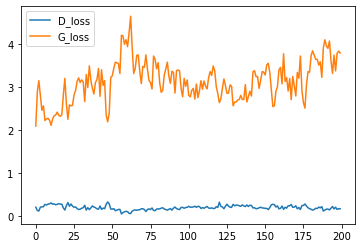

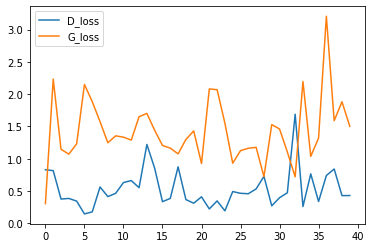

In [12]:
import pandas as pd
print('train_loss')
pd.DataFrame(gan._history[0]['train_loss_data']).plot()
plt.show()
print('test_loss')
pd.DataFrame(gan._history[0]['test_loss_data']).plot()
plt.show()

# Generated Images

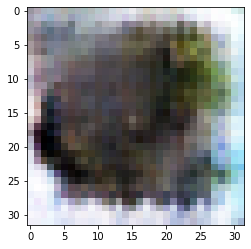

tensor([[0.1513]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [23]:
gan.eval()
gan.g.eval()
gan.d.eval()
generated = gan.sample(1)
btorch.vision.utils.pplot(btorch.vision.utils.img_MinMaxScaler(generated))
print(gan.d(generated))

# Discriminator on Real Image

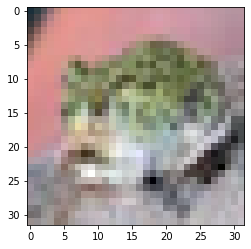

tensor([0.9942], device='cuda:0', grad_fn=<SelectBackward0>)


In [15]:
gan.eval()
gan.g.eval()
gan.d.eval()
for i in train_loader:
  btorch.vision.utils.pplot(btorch.vision.utils.img_MinMaxScaler(i[0][0]))
  print(gan.d(i[0].cuda())[0])
  break

# Evolution of Generator

epoch 0


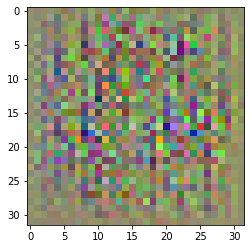

epoch 20


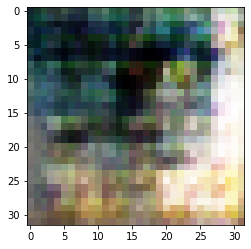

epoch 40


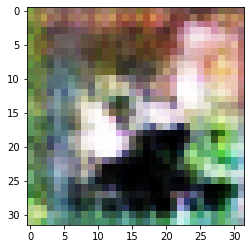

epoch 60


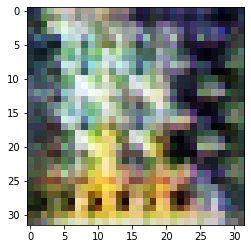

epoch 80


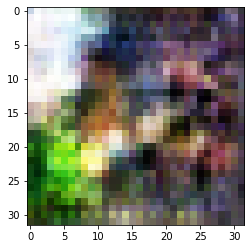

epoch 100


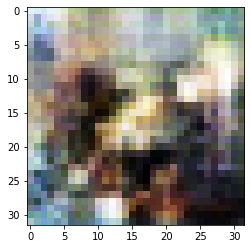

epoch 120


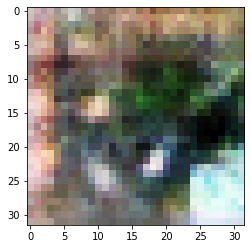

epoch 140


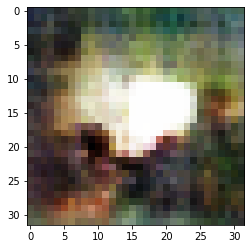

epoch 160


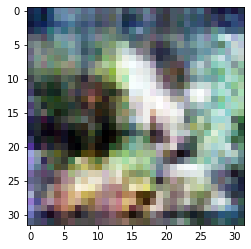

epoch 180


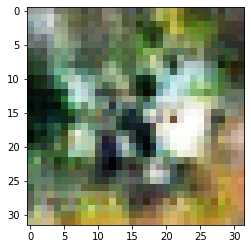

In [31]:
for i in range(0,len(gan._config['evol']), 20):
  print(f"epoch {i}")
  btorch.vision.utils.pplot(btorch.vision.utils.img_MinMaxScaler(gan._config['evol'][i]))